In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 32.3 MB/s eta 0:00:00


In [ ]:
import ee
import geemap
ee.Authenticate()
ee.Initialize(project='ee-crmmn')

#Implementation

In [ ]:
import random

In [ ]:
regions = {
    "New South Wales, Australia": ee.Geometry.Rectangle([145.997, -34.239, 146.397, -33.839]),  # Path/Row: 093/084
    "Wuhan, China": ee.Geometry.Rectangle([113.997, 30.600, 114.397, 31.000])  # Path/Row: 123/039
}

In [ ]:
def get_landsat_images(collection, region, dates):
    images = [
        ee.ImageCollection(collection)
        .filterBounds(region)
        .filterDate(date, ee.Date(date).advance(1, 'day'))
        .select(['B2', 'B3', 'B4', 'B5', 'QA_PIXEL'])
        # Combining images while keeping categorical bands intact
        .mosaic()
        .clip(region)
        for date in dates
    ]
    return images

In [ ]:
def create_cloud_mask(image):
    """Generate a comprehensive cloud mask using all relevant QA_PIXEL flags."""
    qa = image.select("QA_PIXEL").toInt32()

    cloud_bit = qa.bitwiseAnd(1 << 5).neq(0)  # Cloud
    shadow_bit = qa.bitwiseAnd(1 << 3).neq(0)  # Cloud Shadow
    high_confidence = qa.bitwiseAnd(1 << 7).neq(0)  # High Confidence Cloud
    cirrus_bit = qa.bitwiseAnd(1 << 9).neq(0)  # Cirrus (for Landsat 8)

    cloud_mask = cloud_bit.Or(shadow_bit).Or(high_confidence).Or(cirrus_bit)

    return cloud_mask

In [ ]:
def apply_cloud_mask(image, region, cloud_fraction):
    cloud_mask = create_cloud_mask(image)

    # Computing actual cloud cover percentage
    cloud_percentage = cloud_mask.reduceRegion(
        reducer=ee.Reducer.mean(), geometry=region, scale=30
    ).get("QA_PIXEL")

    # Converting to a fraction (since mean gives ratio of cloud pixels)
    cloud_percentage = ee.Algorithms.If(cloud_percentage, ee.Number(cloud_percentage), ee.Number(0))

    # Scaling cloud mask to match target fraction
    scale_factor = ee.Number(cloud_fraction).divide(ee.Number(cloud_percentage)).min(1)
    adjusted_mask = cloud_mask.multiply(scale_factor).gt(0.5)

    return image.updateMask(adjusted_mask.Not()).clip(region).toFloat()

In [ ]:

def generate_fixed_size_patches(image, region, num_patches=100, patch_size=256):
    patches = []

    for _ in range(num_patches):
        center = region.centroid()
        patch = center.buffer((patch_size / 2) * 30).bounds()
        # 30m Landsat resolution
        patches.append(image.clip(patch))

    return patches

In [ ]:
def process_dataset(region_name, collection, dates, num_samples):
    region = regions[region_name]
    landsat_images = get_landsat_images(collection, region, dates)

    # 20%-30%, 10%-20%, 5%-15%
    cloud_levels = [0.25, 0.15, 0.10]
    temporal_images = [apply_cloud_mask(img, region, cloud_levels[i]) for i, img in enumerate(landsat_images)]

    patches = [generate_fixed_size_patches(img, region, num_samples) for img in temporal_images]
    return patches

In [ ]:
def export_patches(patches, description_prefix, folder):
    """Export patches with improved resolution settings."""
    for i, patch_set in enumerate(patches):
        for j, patch in enumerate(patch_set):
            task = ee.batch.Export.image.toDrive(
                image=patch,
                description=f"{description_prefix}_T{i+1}_Patch{j+1}",
                folder=folder,
                scale=15,  # Increased resolution
                region=patch.geometry().bounds().getInfo()['coordinates'],
                fileFormat='GeoTIFF',
                maxPixels=1e13
            )
            task.start()

In [ ]:
nsw_patches = process_dataset(
    "New South Wales, Australia", 'LANDSAT/LT05/C02/T1_TOA', ["2004-11-24", "2004-12-26", "2005-01-11"], 100
)
wuhan_patches = process_dataset(
    "Wuhan, China", 'LANDSAT/LC08/C02/T1_TOA', ["2013-05-12", "2013-06-13", "2013-07-31"], 100
)

In [ ]:
export_patches(nsw_patches, "Australia", "CMSN_Dataset")
export_patches(wuhan_patches, "Wuhan", "CMSN_Dataset")

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
tiff_path = '/content/drive/MyDrive/CMSN_Dataset/Wuhan_T1_Patch9.tif'

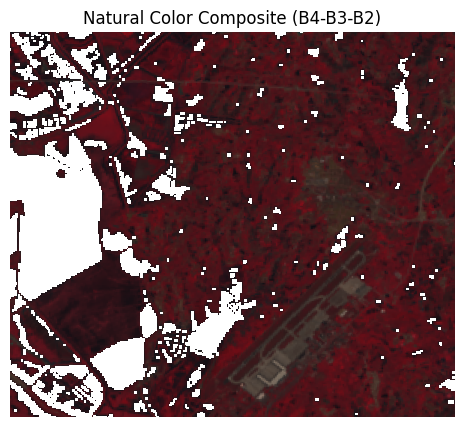

In [ ]:
with rasterio.open(tiff_path) as src:
    red = src.read(4).astype(np.float32)
     # Band 4 (Red)
    green = src.read(3).astype(np.float32)
    # Band 3 (Green)
    blue = src.read(2).astype(np.float32)
    # Band 2 (Blue)

rgb_image = np.dstack((red, green, blue))

plt.figure(figsize=(10, 5))
plt.imshow(rgb_image)
plt.axis("off")
plt.title("Natural Color Composite (B4-B3-B2)")
plt.show()

In [ ]:

with rasterio.open(tiff_path) as src:
    print("Resolution:", src.res)

Resolution: (0.00013474729261792824, 0.00013474729261792824)


#Pipeline attempt : 2

In [ ]:
import torch
import torch.nn as nn
import torch.fft
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
from torchvision import transforms
from PIL import Image

In [ ]:
class ResFFTConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResFFTConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        fft_x = torch.fft.fft2(x, norm="ortho")
        fft_x = torch.abs(fft_x)
        fft_x = fft_x / (fft_x.mean() + 1e-8)

        out = self.conv1(fft_x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        return F.relu(out + self.skip(fft_x))

class MFAM(nn.Module):

    def __init__(self, channels):
        super(MFAM, self).__init__()
        self.conv1 = nn.Conv2d(channels * 3, channels, kernel_size=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x1, x2, x3):
        fused = torch.cat([x1, x2, x3], dim=1)
        attn = F.relu(self.conv1(fused))
        return F.relu(self.conv2(attn))

class CMSN(nn.Module):

    def __init__(self, in_channels=4, features=64):
        super(CMSN, self).__init__()
        self.encoder1 = ResFFTConv(in_channels, features)
        self.encoder2 = ResFFTConv(features, features * 2)
        self.mfam = MFAM(features * 2)
        self.decoder = nn.Conv2d(features * 2, in_channels, kernel_size=3, padding=1)
        self.refine_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, t1, t2, t3):
        e1 = self.encoder1(t1)
        e2 = self.encoder2(e1)
        fused = self.mfam(e2, e2, e2)

        coarse_out = self.decoder(fused)
        # Coarse output
        refined_out = torch.tanh(self.refine_conv(coarse_out))
        # Refined output

        return coarse_out, refined_out

In [ ]:
class CMSNDataset(Dataset):

    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = self._load_samples()
    def _load_samples(self):
        files = sorted(os.listdir(self.root_dir))


        regions = sorted(set(f.split('_')[0] for f in files if 'Patch' in f))

        samples = []
        for region in regions:
            patch_indices = sorted(set(f.split('_Patch')[-1].split('.')[0] for f in files if region in f and 'Patch' in f))

            for idx in patch_indices:
                t1_file = f"{self.root_dir}/{region}_T1_Patch{idx}.tif"
                t2_file = f"{self.root_dir}/{region}_T2_Patch{idx}.tif"
                t3_file = f"{self.root_dir}/{region}_T3_Patch{idx}.tif"

                if all(os.path.exists(f) for f in [t1_file, t2_file, t3_file]):
                    samples.append((t1_file, t2_file, t3_file))

        print(f"Total Samples Found: {len(samples)}")
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        t1_path, t2_path, t3_path = [os.path.join(self.root_dir, f) for f in self.samples[idx]]
        t1, t2, t3 = [self._load_image(p) for p in [t1_path, t2_path, t3_path]]
        return t1, t2, t3

    def _load_image(self, path):
        with rasterio.open(path) as src:
            img = src.read(out_dtype='float32')

            # Replacing NaN values with 0
            img = np.nan_to_num(img, nan=0.0)

        img = torch.tensor(img[:4])
        img = T.Resize((256, 256))(img)

        return img

In [ ]:
class CMSNLoss(nn.Module):
    def __init__(self, lambda_gl=0.3, delta=0.01, xi=0.2):

        super(CMSNLoss, self).__init__()
        self.lambda_gl = lambda_gl
        self.delta = delta
        self.xi = xi

    def global_local_loss(self, T1k, Rk, Mk):

        loss_cloud_free = F.l1_loss(T1k * Mk, Rk * Mk)
        loss_cloud_covered = F.l1_loss(T1k * (1 - Mk), Rk * (1 - Mk))
        return loss_cloud_free + self.lambda_gl * loss_cloud_covered
    def frequency_loss(self, T1k, Rk):
        fft_T1k = torch.fft.fft2(T1k).abs()
        fft_Rk = torch.fft.fft2(Rk).abs()

        fft_T1k = fft_T1k / (fft_T1k.mean() + 1e-8)
        fft_Rk = fft_Rk / (fft_Rk.mean() + 1e-8)

        return F.l1_loss(fft_T1k, fft_Rk)

    def refinement_loss(self, T2k, Rk):

        return F.l1_loss(T2k, Rk)

    def forward(self, T1_pred, T2_pred, R, M):

        # multi-temporal losses
        mtgl_loss = self.global_local_loss(T1_pred, R, M)
        mtfr_loss = self.frequency_loss(T1_pred, R)
        refine_loss = self.refinement_loss(T2_pred, R)

        #totla loss
        loss_coarse = mtgl_loss + self.delta * mtfr_loss
        total_loss = loss_coarse + self.xi * refine_loss

        return total_loss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
def train_cmsn(model, dataloader, epochs=200, lr=7e-3):


    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.9)
    criterion = CMSNLoss(lambda_gl=0.15, delta=0.01, xi=0.3)
    criterion.to(device)

    for epoch in range(epochs):
        total_loss = 0
        model.train()

        for t1, t2, t3 in dataloader:

            t1, t2, t3 = t1.to(device), t2.to(device), t3.to(device)

            optimizer.zero_grad()
            T1_pred, T2_pred = model(t1, t2, t3)


            t1_norm = (t1 - t1.min()) / (t1.max() - t1.min() + 1e-8)
            M = (t1.mean(dim=1, keepdim=True) < 0.3).float().to(device)


            loss = criterion(T1_pred, T2_pred, t1, M)

            if torch.isnan(loss):
                print("NaN detected in loss! Skipping batch")
                continue

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")

    print("Training complete!")

In [ ]:
dataset = CMSNDataset(root_dir="/content/drive/MyDrive/CMSN_Dataset")
print(f"Total Samples Loaded: {len(dataset)}")

Total Samples Found: 200
Total Samples Loaded: 200


In [ ]:
for i in range(3):
    t1, t2, t3 = dataset[i]
    print(f"Sample {i+1}")
    print(f"T1 Shape: {t1.shape}, Min: {t1.min()}, Max: {t1.max()}")
    print(f"T2 Shape: {t2.shape}, Min: {t2.min()}, Max: {t2.max()}")
    print(f"T3 Shape: {t3.shape}, Min: {t3.min()}, Max: {t3.max()}")

Sample 1
T1 Shape: torch.Size([4, 256, 256]), Min: 0.03765235096216202, Max: 0.4187355041503906
T2 Shape: torch.Size([4, 256, 256]), Min: 0.037944234907627106, Max: 0.42604100704193115
T3 Shape: torch.Size([4, 256, 256]), Min: 0.03789852187037468, Max: 0.41364529728889465
Sample 2
T1 Shape: torch.Size([4, 256, 256]), Min: 0.03765235096216202, Max: 0.4187355041503906
T2 Shape: torch.Size([4, 256, 256]), Min: 0.037944234907627106, Max: 0.42604100704193115
T3 Shape: torch.Size([4, 256, 256]), Min: 0.03789852187037468, Max: 0.41364529728889465
Sample 3
T1 Shape: torch.Size([4, 256, 256]), Min: 0.03765235096216202, Max: 0.4187355041503906
T2 Shape: torch.Size([4, 256, 256]), Min: 0.037944234907627106, Max: 0.42604100704193115
T3 Shape: torch.Size([4, 256, 256]), Min: 0.03789852187037468, Max: 0.41364529728889465


In [ ]:

dataloader = DataLoader(dataset, batch_size=16, shuffle=True, pin_memory=True)
model = CMSN()
train_cmsn(model, dataloader)

Epoch 1/200, Loss: 2.5640
Epoch 2/200, Loss: 0.0796
Epoch 3/200, Loss: 0.0663
Epoch 4/200, Loss: 0.0623
Epoch 5/200, Loss: 0.0600
Epoch 6/200, Loss: 0.0562
Epoch 7/200, Loss: 0.0548
Epoch 8/200, Loss: 0.0541
Epoch 9/200, Loss: 0.0532
Epoch 10/200, Loss: 0.0526
Epoch 11/200, Loss: 0.0522
Epoch 12/200, Loss: 0.0516
Epoch 13/200, Loss: 0.0516
Epoch 14/200, Loss: 0.0514
Epoch 15/200, Loss: 0.0507
Epoch 16/200, Loss: 0.0507
Epoch 17/200, Loss: 0.0503
Epoch 18/200, Loss: 0.0497
Epoch 19/200, Loss: 0.0494
Epoch 20/200, Loss: 0.0497
Epoch 21/200, Loss: 0.0522
Epoch 22/200, Loss: 0.0509
Epoch 23/200, Loss: 0.0503
Epoch 24/200, Loss: 0.0492
Epoch 25/200, Loss: 0.0488
Epoch 26/200, Loss: 0.0483
Epoch 27/200, Loss: 0.0463
Epoch 28/200, Loss: 0.0455
Epoch 29/200, Loss: 0.0435
Epoch 30/200, Loss: 0.0422
Epoch 31/200, Loss: 0.0400
Epoch 32/200, Loss: 0.0417
Epoch 33/200, Loss: 0.0383
Epoch 34/200, Loss: 0.0362
Epoch 35/200, Loss: 0.0352
Epoch 36/200, Loss: 0.0341
Epoch 37/200, Loss: 0.0349
Epoch 38/2

In [ ]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"{name}: {param.grad.abs().mean().item()}")

encoder1.conv1.weight: 8.155557588906959e-05
encoder1.conv1.bias: 1.960098749975714e-11
encoder1.bn1.weight: 4.789873491972685e-05
encoder1.bn1.bias: 5.4841188102727756e-05
encoder1.conv2.weight: 1.4110873053141404e-05
encoder1.conv2.bias: 1.674660410344586e-11
encoder1.bn2.weight: 0.00011605891631916165
encoder1.bn2.bias: 2.514218067517504e-05
encoder1.skip.weight: 0.0005544812884181738
encoder1.skip.bias: 2.514218067517504e-05
encoder2.conv1.weight: 9.609543667465914e-06
encoder2.conv1.bias: 4.777178652659586e-12
encoder2.bn1.weight: 6.360793486237526e-05
encoder2.bn1.bias: 6.375506927724928e-05
encoder2.conv2.weight: 3.2530676890019095e-06
encoder2.conv2.bias: 7.117752567897817e-13
encoder2.bn2.weight: 0.00011262866610195488
encoder2.bn2.bias: 0.00010454857692820951
encoder2.skip.weight: 9.610581037122756e-05
encoder2.skip.bias: 0.00010454857692820951
mfam.conv1.weight: 4.933047421218362e-06
mfam.conv1.bias: 0.0013628136366605759
mfam.conv2.weight: 2.251287924082135e-06
mfam.conv2.b

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')
torch.save(model, 'full_model.pth')

In [ ]:
def calculate_ndvi(image):

    red = image[2]
    nir = image[3]

    if nir.max() > 1 or red.max() > 1:
        red = red / 10000.0
        nir = nir / 10000.0

    ndvi = (nir - red) / (nir + red + 1e-8)
    return torch.clamp(ndvi, min=-1, max=1)

In [ ]:
sample_idx = 70
t1_path, t2_path, t3_path = dataset.samples[sample_idx]

# Loadingg the image
t1, t2, t3 = dataset._load_image(t1_path), dataset._load_image(t2_path), dataset._load_image(t3_path)

t1, t2, t3 = t1.unsqueeze(0), t2.unsqueeze(0), t3.unsqueeze(0)

NDVI (Predicted): 0.1659
NDVI (Ground Truth): 0.1765
NDVI Difference: 0.0106


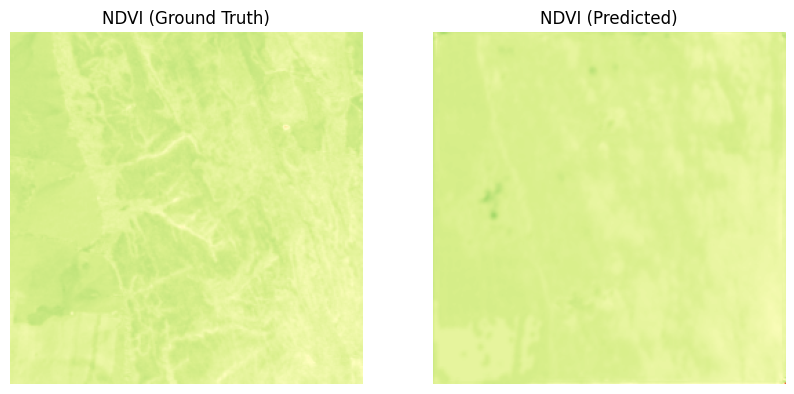

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

t1, t2, t3 = t1.to(device), t2.to(device), t3.to(device)

with torch.no_grad():
    T1_pred, T2_pred = model(t1, t2, t3)

T2_pred_cpu = T2_pred.squeeze(0).cpu()
t1_cpu = t1.squeeze(0).cpu()


ndvi_pred_map = calculate_ndvi(T2_pred_cpu)
 # Shape: (256, 256)
ndvi_true_map = calculate_ndvi(t1_cpu)
 # Shape: (256, 256)


ndvi_pred = ndvi_pred_map.mean().item()
ndvi_true = ndvi_true_map.mean().item()
ndvi_diff = abs(ndvi_pred - ndvi_true)

print(f"NDVI (Predicted): {ndvi_pred:.4f}")
print(f"NDVI (Ground Truth): {ndvi_true:.4f}")
print(f"NDVI Difference: {ndvi_diff:.4f}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))


ax[0].imshow(ndvi_true_map, cmap='RdYlGn', vmin=-1, vmax=1)
ax[0].set_title("NDVI (Ground Truth)")
ax[0].axis("off")

ax[1].imshow(ndvi_pred_map, cmap='RdYlGn', vmin=-1, vmax=1)
ax[1].set_title("NDVI (Predicted)")
ax[1].axis("off")

plt.show()

In [ ]:
print(f"T2_pred shape: {T2_pred.shape}")

T2_pred shape: torch.Size([1, 4, 256, 256])


In [ ]:
print(f"Predicted Red Min: {T2_pred[0][2].min().item()}, Max: {T2_pred[0][2].max().item()}")
print(f"Predicted NIR Min: {T2_pred[0][3].min().item()}, Max: {T2_pred[0][3].max().item()}")

print(f"Ground Truth Red Min: {t1[0][2].min().item()}, Max: {t1[0][2].max().item()}")
print(f"Ground Truth NIR Min: {t1[0][3].min().item()}, Max: {t1[0][3].max().item()}")

print(f"Predicted Red Std: {T2_pred[0][2].std().item()}")
print(f"Predicted NIR Std: {T2_pred[0][3].std().item()}")

Predicted Red Min: 0.013312228955328465, Max: 0.3914528787136078
Predicted NIR Min: 0.005238316487520933, Max: 0.6748790740966797
Ground Truth Red Min: 0.06895634531974792, Max: 0.3454580008983612
Ground Truth NIR Min: 0.08304660022258759, Max: 0.4187355041503906
Predicted Red Std: 0.04450425133109093
Predicted NIR Std: 0.07056545466184616


In [ ]:

t1, t2, t3 = dataset[140]
t1, t2, t3 = t1.unsqueeze(0), t2.unsqueeze(0), t3.unsqueeze(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
t1, t2, t3 = t1.to(device), t2.to(device), t3.to(device)

model.eval()
with torch.no_grad():
    coarse_pred, refined_pred = model(t1, t2, t3)

In [ ]:
def tensor_to_image(tensor):

    img = tensor.squeeze(0).detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0, 1)
    return img

t1_img = tensor_to_image(t1)
t2_img = tensor_to_image(t2)
t3_img = tensor_to_image(t3)
coarse_pred_img = tensor_to_image(coarse_pred)
refined_pred_img = tensor_to_image(refined_pred)

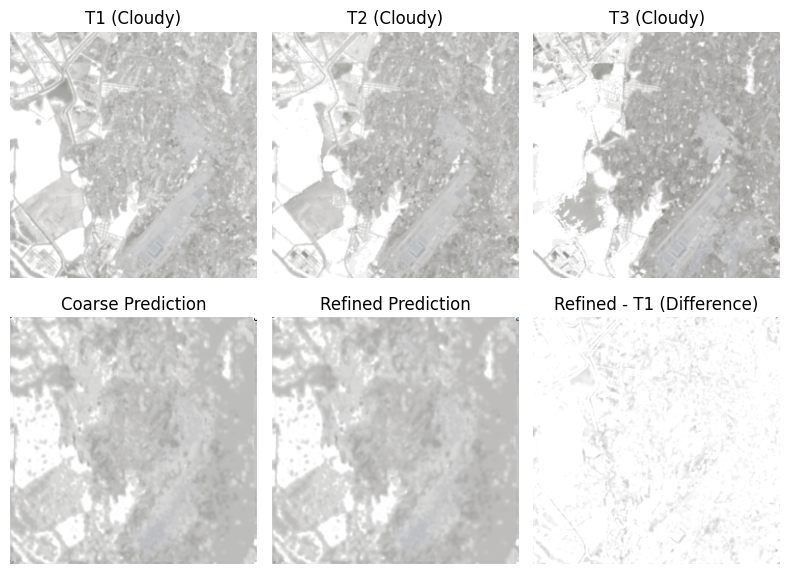

In [ ]:

fig, axes = plt.subplots(2, 3, figsize=(8, 6))

axes[0, 0].imshow(t1_img)
axes[0, 0].set_title("T1 (Cloudy)")
axes[0, 1].imshow(t2_img)
axes[0, 1].set_title("T2 (Cloudy)")
axes[0, 2].imshow(t3_img)
axes[0, 2].set_title("T3 (Cloudy)")

axes[1, 0].imshow(coarse_pred_img)
axes[1, 0].set_title("Coarse Prediction")
axes[1, 1].imshow(refined_pred_img)
axes[1, 1].set_title("Refined Prediction")
axes[1, 2].imshow(t1_img-refined_pred_img)
axes[1, 2].set_title("Refined - T1 (Difference)")

for ax in axes.flatten():
    ax.axis("off")

plt.tight_layout()
plt.show()

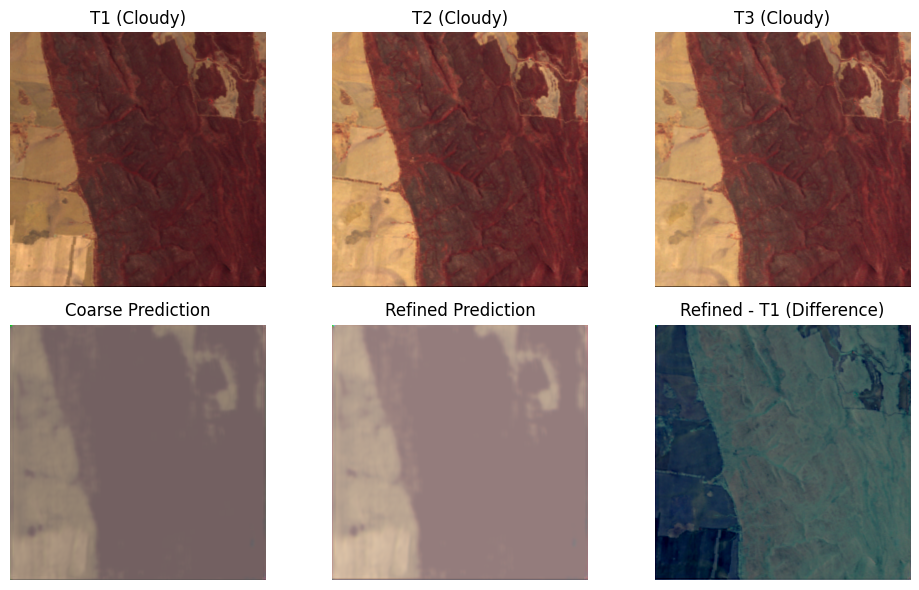

In [ ]:
def tensor_to_rgb_image(tensor):

    tensor = tensor.squeeze(0).detach().cpu()
    rgb = torch.stack([tensor[2], tensor[1], tensor[0]])
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)
    return np.transpose(rgb.numpy(), (1, 2, 0))

t1_rgb = tensor_to_rgb_image(t1)
t2_rgb = tensor_to_rgb_image(t2)
t3_rgb = tensor_to_rgb_image(t3)
coarse_rgb = tensor_to_rgb_image(coarse_pred)
refined_rgb = tensor_to_rgb_image(refined_pred)
diff_rgb = np.clip(refined_rgb - t1_rgb, 0, 1)

fig, axes = plt.subplots(2, 3, figsize=(10, 6))

axes[0, 0].imshow(t1_rgb)
axes[0, 0].set_title("T1 (Cloudy)")
axes[0, 1].imshow(t2_rgb)
axes[0, 1].set_title("T2 (Cloudy)")
axes[0, 2].imshow(t3_rgb)
axes[0, 2].set_title("T3 (Cloudy)")

axes[1, 0].imshow(coarse_rgb)
axes[1, 0].set_title("Coarse Prediction")
axes[1, 1].imshow(refined_rgb)
axes[1, 1].set_title("Refined Prediction")
axes[1, 2].imshow(diff_rgb)
axes[1, 2].set_title("Refined - T1 (Difference)")

for ax in axes.flatten():
    ax.axis("off")

plt.tight_layout()
plt.show()
